<a href="https://colab.research.google.com/github/iuryt/OceanGyreTank.jl/blob/main/OceanGyreTank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.5" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools GR_jll Plots GLMakie Oceananigans"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.6.5 on the current Colab Runtime...
2022-03-19 18:48:27 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.5-linux-x86_64.tar.gz [113278959/113278959] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package Plots...
Installing Julia package Oceananigans...
Installing Julia package CUDA...


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.6.5
Commit 9058264a69 (2021-12-19 12:30 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
Environment:
  JULIA_NUM_THREADS = 2


In [2]:
using BenchmarkTools

M = rand(2^11, 2^11)

@btime $M * $M;

  481.667 ms (2 allocations: 32.00 MiB)


In [4]:
if ENV["COLAB_GPU"] == "1"
    using CUDA

    run(`nvidia-smi`)

    # Create a new random matrix directly on the GPU:
    M_on_gpu = CUDA.CURAND.rand(2^11, 2^11)
    @btime $M_on_gpu * $M_on_gpu; nothing
else
    println("No GPU found.")
end

Sat Mar 19 18:57:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Now let's setup our numerical simulation

In [23]:
using Plots
using Oceananigans
using Oceananigans.Units
using Oceananigans.ImmersedBoundaries: ImmersedBoundaryGrid, GridFittedBottom, GridFittedBoundary, mask_immersed_field!

In [6]:
const cᴰ = 2.5e-3     # dimensionless drag coefficient
const ρₐ = 1.225      # kg m⁻³, average density of air at sea-level
const ρₒ = 1026       # kg m⁻³, average density at the surface of the ocean
const L = 0.23meters
const H = 0.15meters
const Ny = 100
const Nx = 100
const Nz = 20

20

In [24]:
underlying_grid = RectilinearGrid(GPU(),
    size=(Nx, Ny, Nz),
    x=(-L, L),
    y=(-L, L),
    z=(-H,0),
    topology=(Bounded, Bounded, Bounded)
)

@inline radius(x,y) = sqrt(x^2 + y^2)
@inline tank(x, y) = ifelse(radius(x,y)<L,-H,0)
grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(tank))

┌ Warning: ImmersedBoundaryGrid is unvalidated and may produce incorrect results. Help validate ImmersedBoundaryGrid by reporting any bugs or unexpected behavior to https://github.com/CliMA/Oceananigans.jl/issues.
└ @ Oceananigans.ImmersedBoundaries /root/.julia/packages/Oceananigans/JIHfS/src/ImmersedBoundaries/ImmersedBoundaries.jl:106


ImmersedBoundaryGrid on: 
    architecture: GPU()
            grid: 100×100×20 RectilinearGrid{Float64, Bounded, Bounded, Bounded} on GPU with 1×1×1 halo
   with immersed: GridFittedBottom{typeof(tank)}

In [25]:
@inline U(x,y,L)    = sin(π*radius(x,y)/L)*exp(1im*angle(x+y*1im))
@inline Qᵘ(x,y,t) = ifelse(radius(x,y)<L,  imag(ρₐ / ρₒ * cᴰ * U(x,y,L)*abs(U(x,y,L))), 0) # m² s⁻²
@inline Qᵛ(x,y,t) = ifelse(radius(x,y)<L, -real(ρₐ / ρₒ * cᴰ * U(x,y,L)*abs(U(x,y,L))), 0) # m² s⁻²

u_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵘ))
v_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵛ))

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition
├── east: DefaultBoundaryCondition
├── south: DefaultBoundaryCondition
├── north: DefaultBoundaryCondition
├── bottom: DefaultBoundaryCondition
├── top: FluxBoundaryCondition: ContinuousBoundaryFunction Qᵛ at (Nothing, Nothing, Nothing)
└── immersed: FluxBoundaryCondition: Nothing

In [26]:
coriolis = BetaPlane(f₀=2.0944,β=1.6)

BetaPlane{Float64}(f₀=2.0944, β=1.6)

In [ ]:
model = NonhydrostaticModel(grid = grid,
                            advection = WENO5(),
                            tracers = (:T, :S),
                            coriolis = coriolis,
                            buoyancy = SeawaterBuoyancy(),
                            closure = ScalarDiffusivity(ν=1e-6,κ=1e-6),
                            boundary_conditions = (u=u_bcs,v=v_bcs))

set!(model,T=25,S=0)

In [16]:
simulation = Simulation(model, Δt = 0.1second, stop_time = 40seconds)

simulation.output_writers[:velocities] =
    JLD2OutputWriter(model, model.velocities, prefix = "velocities",
                     schedule=TimeInterval(0.1second), force = true)

run!(simulation)

┌ Warning: Cannot serialize timeseries/u/serialized/boundary_conditions as it contains functions. Will replace with missing. Function boundary conditions must be restored manually.
└ @ Oceananigans.OutputWriters /root/.julia/packages/Oceananigans/JIHfS/src/OutputWriters/output_writer_utils.jl:70
┌ Warning: Cannot serialize timeseries/v/serialized/boundary_conditions as it contains functions. Will replace with missing. Function boundary conditions must be restored manually.
└ @ Oceananigans.OutputWriters /root/.julia/packages/Oceananigans/JIHfS/src/OutputWriters/output_writer_utils.jl:70
┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations /root/.julia/packages/Oceananigans/JIHfS/src/Simulations/run.jl:167
┌ Info:     ... simulation initialization complete (25.367 ms)
└ @ Oceananigans.Simulations /root/.julia/packages/Oceananigans/JIHfS/src/Simulations/run.jl:202
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations /root/.julia/packages/Oceananigans/JIHfS/src/S

In [17]:
u = FieldTimeSeries("velocities.jld2", "u")
v = FieldTimeSeries("velocities.jld2", "v")

100×101×20×101 FieldTimeSeries{InMemory} located at (Center, Face, Center) on CPU
├── grid: 100×100×20 RectilinearGrid{Float64, Bounded, Bounded, Bounded} on CPU with 1×1×1 halo
├── indices: (1:100, 1:101, 1:20)
└── data: 100×101×20×101 OffsetArray(::Array{Float64, 4}, 1:100, 1:101, 1:20, 1:101) with eltype Float64 with indices 1:100×1:101×1:20×1:101
    └── max=0.00033518, min=-0.000387029, mean=3.55901e-16

┌ Info: Saved animation to 
│   fn = /content/animation.gif
└ @ Plots /root/.julia/packages/Plots/8K4be/src/animation.jl:114


Plots.AnimatedGif("/content/animation.gif")
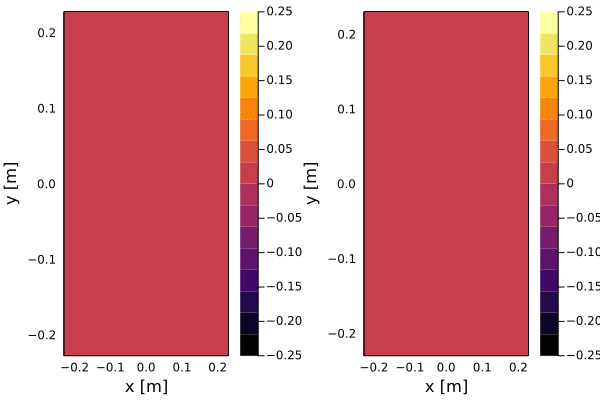

In [22]:
xu,yu,zu = nodes(u)
xv,yv,zv = nodes(v)


anim = @animate for (i, t) in enumerate(u.times)
    p1 = contour(xu,yu,u[:,:,1,i]'.*1e3; xlabel="x [m]", ylabel="y [m]", clim = (-0.25,0.25), fill=true, linewidth=0.2)
    p2 = contour(xv,yv,v[:,:,1,i]'.*1e3; xlabel="x [m]", ylabel="y [m]", clim = (-0.25,0.25), fill=true, linewidth=0.2)
    plot(p1,p2)
end

gif(anim, "animation.gif", fps = 10)